In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

In [3]:
import sys
sys.path.insert(0, '/Users/mrahimi/AVM/module/')
import Plot
pl = Plot.Plot()

# Client Agent 2018

In [4]:
df = pd.read_csv("client_agent.csv")

In [5]:
df.shape

(4156109, 11)

In [6]:
df.columns = [x.lower() for x in df.columns]

In [7]:
df.columns

Index(['client_id', 'customer_id', 'agent_id', 'create_date',
       'contact_relation_desc_id', 'metro', 'lr_source_name',
       'lr_website_name', 'lr_lead_status_name', 'customer_comment',
       'client_type'],
      dtype='object')

In [8]:
df.lr_lead_status_name.value_counts()

Drip                                 2027661
Hot Prospect                         1112054
Bogus                                 432507
Cold                                   80975
closed                                 56561
Needs Reassignment                     54875
Proposed Bogus                         33732
halted                                 28344
Proposed Cold                          21826
halted source                          16020
Closed - Transaction Match Needed       5285
delayed                                 3982
Hot Sales Contract Accepted             3596
recruiting                               912
Hot Agreement Signed                     283
halted lag                               119
proposed recruiting                      108
IVR In Progress                           22
Name: lr_lead_status_name, dtype: int64

In [84]:
index = (df.lr_lead_status_name == "closed") | (df.lr_lead_status_name == "Cold")
dd = df.loc[index, ["customer_comment", "lr_lead_status_name"]]
dd.shape

(137536, 2)

In [85]:
dd = dd[~dd.customer_comment.isnull()]
dd.shape

(52380, 2)

In [86]:
dd.head()

,customer_comment,lr_lead_status_name
5,I would like more information regarding the pr...,Cold
47,This lead is for CHERRIE WOODWARD. The Cartus ...,closed
48,Hello please can you help me buy a house for m...,Cold
66,Client is looking for a single family home in ...,Cold
185,I would like more information regarding the pr...,Cold


In [87]:
dd.lr_lead_status_name.value_counts()

Cold      40540
closed    11840
Name: lr_lead_status_name, dtype: int64

In [88]:
dd = pd.concat([dd[dd.lr_lead_status_name == "Cold"].sample(11840), dd[dd.lr_lead_status_name == "closed"]], axis=0)
dd.lr_lead_status_name.value_counts()

closed    11840
Cold      11840
Name: lr_lead_status_name, dtype: int64

In [170]:
dd.to_csv("customer_comments.csv", index=False)

# Clean Text

In [89]:
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def text_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()

In [90]:
dd["customer_comment"] = dd["customer_comment"].apply(lambda x: text_cleaner(x))

# Word Visualisation

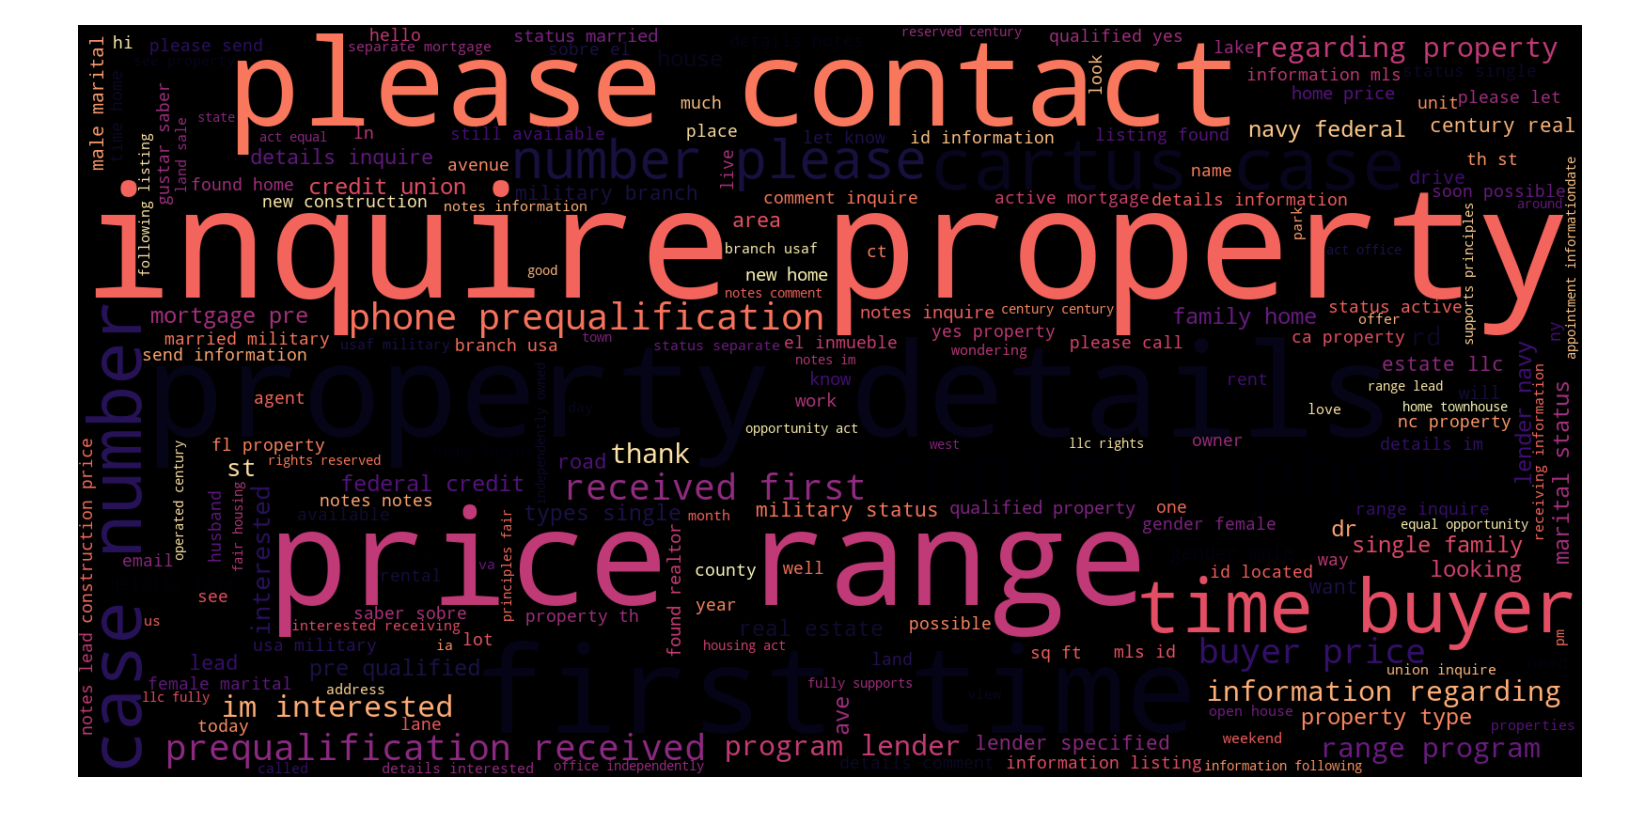

In [91]:
neg_text = dd[dd.lr_lead_status_name == "Cold"]
neg_string = []
for t in neg_text.customer_comment:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200, colormap='magma').generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

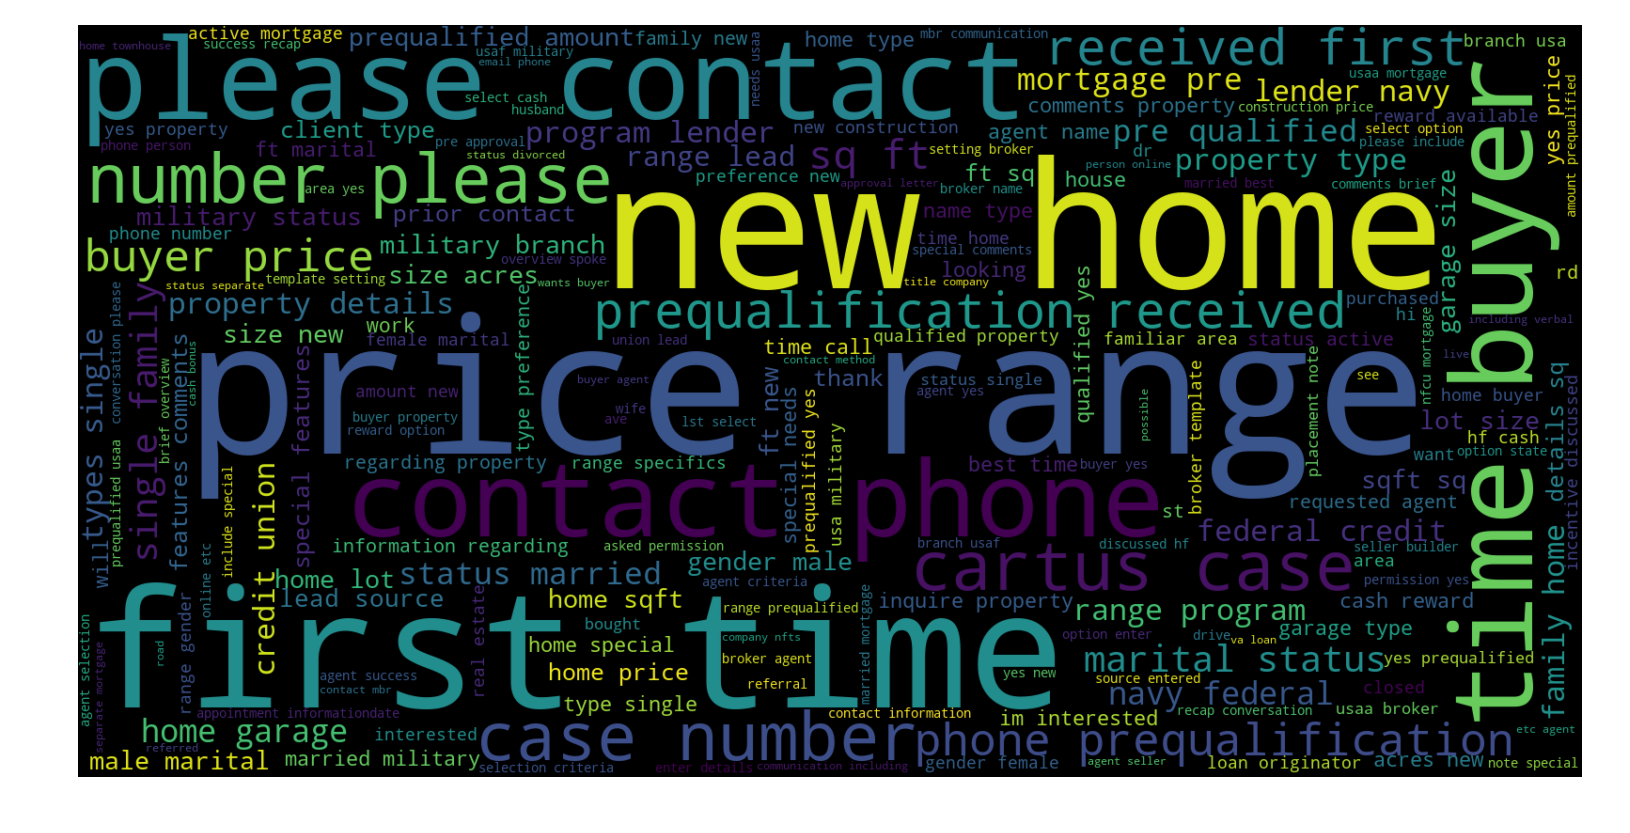

In [92]:
neg_text = dd[dd.lr_lead_status_name == "closed"]
neg_string = []
for t in neg_text.customer_comment:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Frequency

In [99]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer(max_df = 1.0)
cvec.fit(dd.customer_comment)
len(cvec.get_feature_names())

19601

In [100]:
neg_doc_matrix = cvec.transform(dd[dd.lr_lead_status_name == "Cold"].customer_comment)
pos_doc_matrix = cvec.transform(dd[dd.lr_lead_status_name == "closed"].customer_comment)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()
term_freq_df.columns = ["neg", "pos"]

In [101]:
term_freq_df["total"] = term_freq_df["neg"] + term_freq_df["pos"]

In [103]:
term_freq_df.sort_values(by=["total"]).tail()

,neg,pos,total
in,3852,4582,8434
property,5796,2900,8696
the,7532,6806,14338
to,7303,7773,15076
is,5993,9468,15461


Text(0.5,1,'Top 500 tokens in comments')

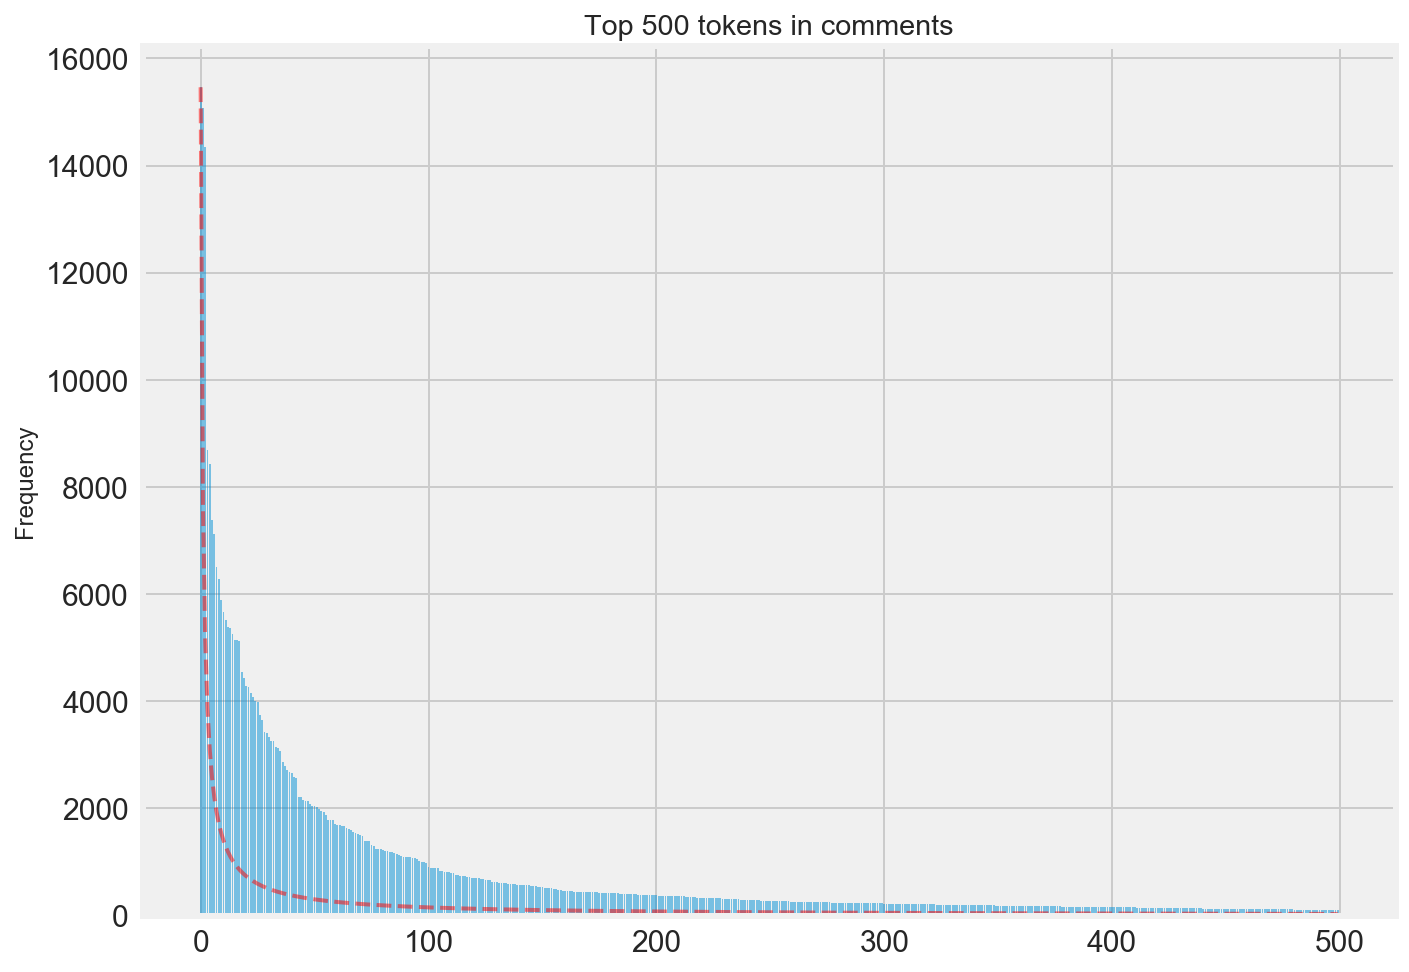

In [106]:
y_pos = np.arange(500)
plt.figure(figsize=(10,8))
s = 1
expected_zipf = [term_freq_df.sort_values(by='total', ascending=False)['total'][0]/(i+1)**s for i in y_pos]
plt.bar(y_pos, term_freq_df.sort_values(by='total', ascending=False)['total'][:500], align='center', alpha=0.5)
plt.plot(y_pos, expected_zipf, color='r', linestyle='--',linewidth=2,alpha=0.5)
plt.ylabel('Frequency')
plt.title('Top 500 tokens in comments')

Text(0.5,1,'Top 50 tokens in comments')

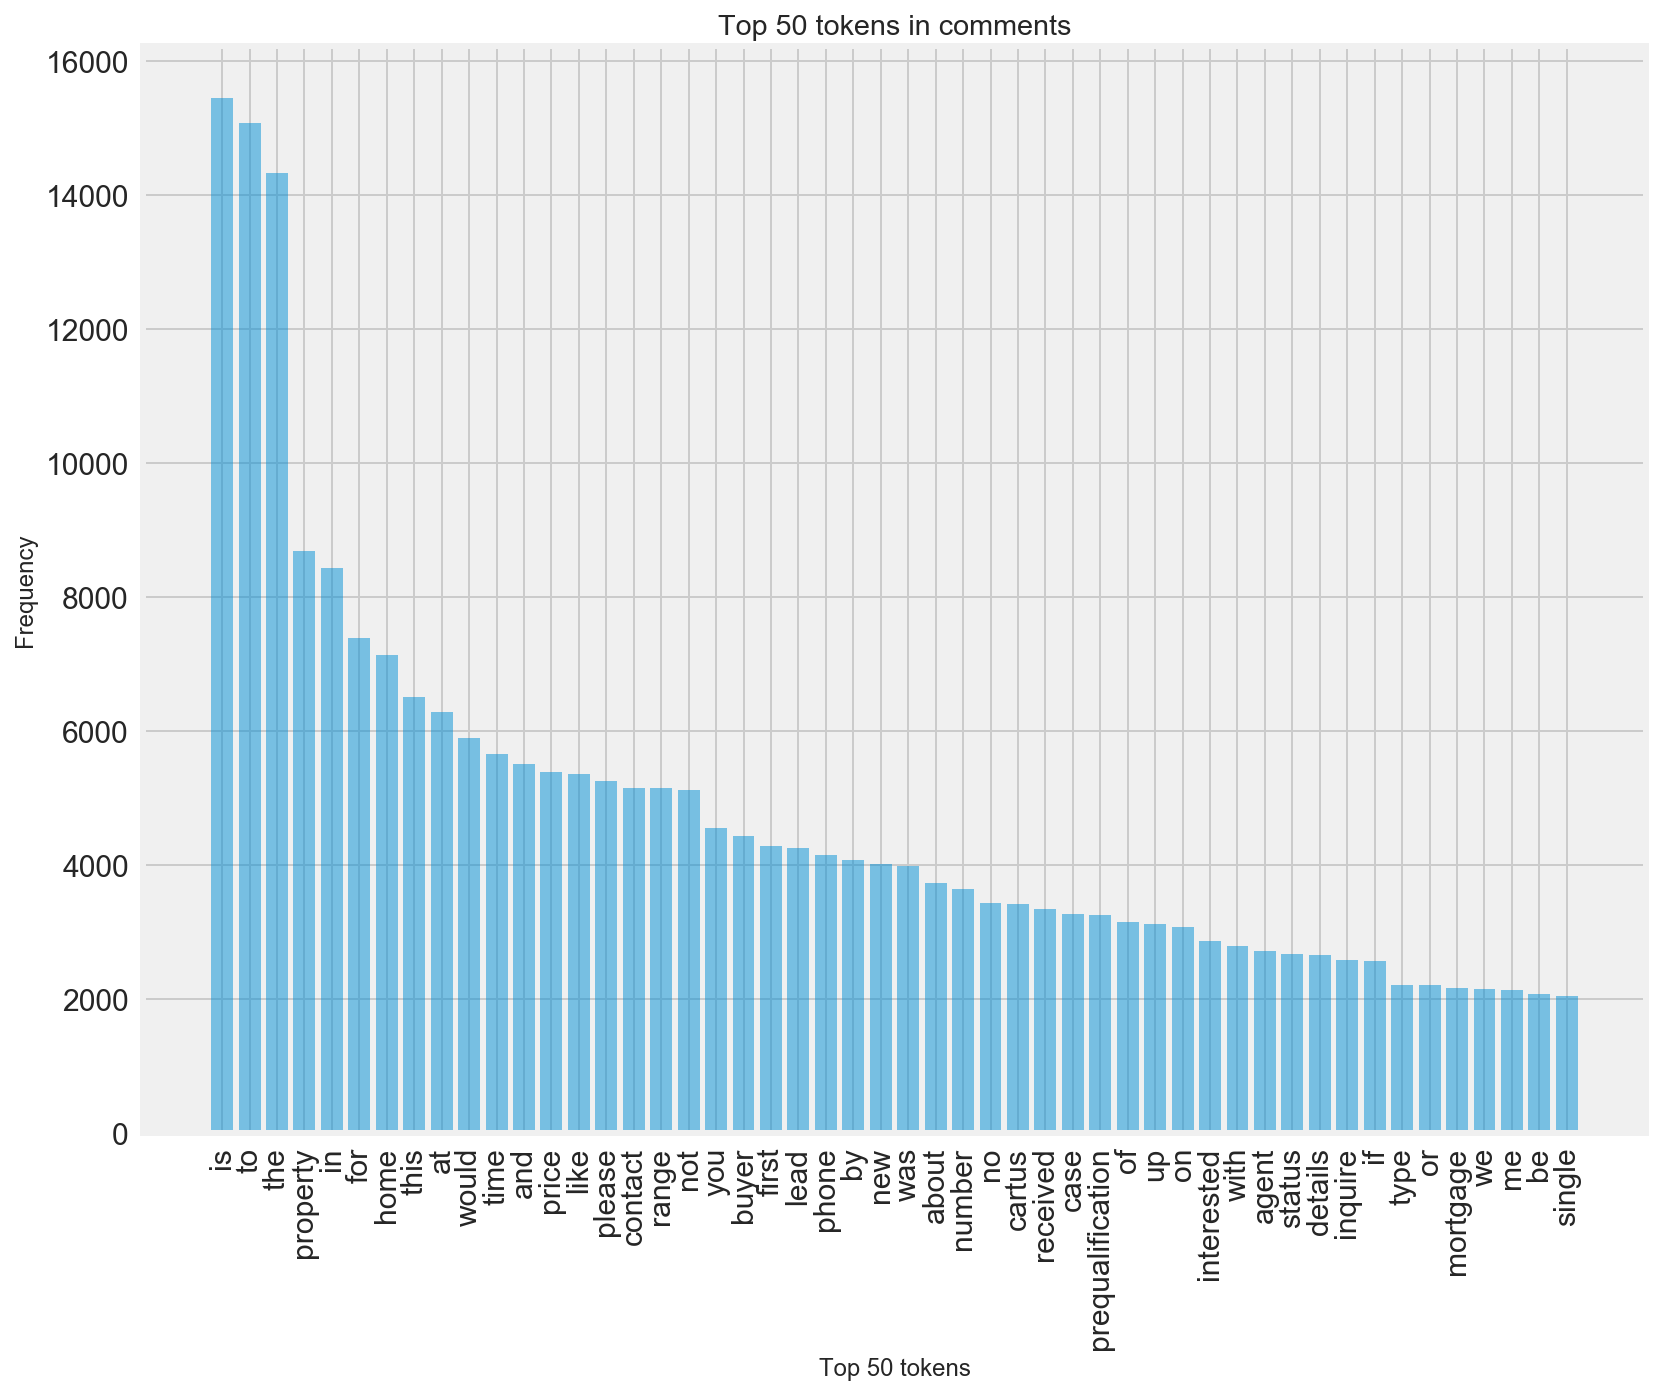

In [113]:
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df.sort_values(by='total', ascending=False)['total'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df.sort_values(by='total', ascending=False)['total'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 tokens')
plt.title('Top 50 tokens in comments')

Text(0.5,1,'Top 50 tokens in negative comments')

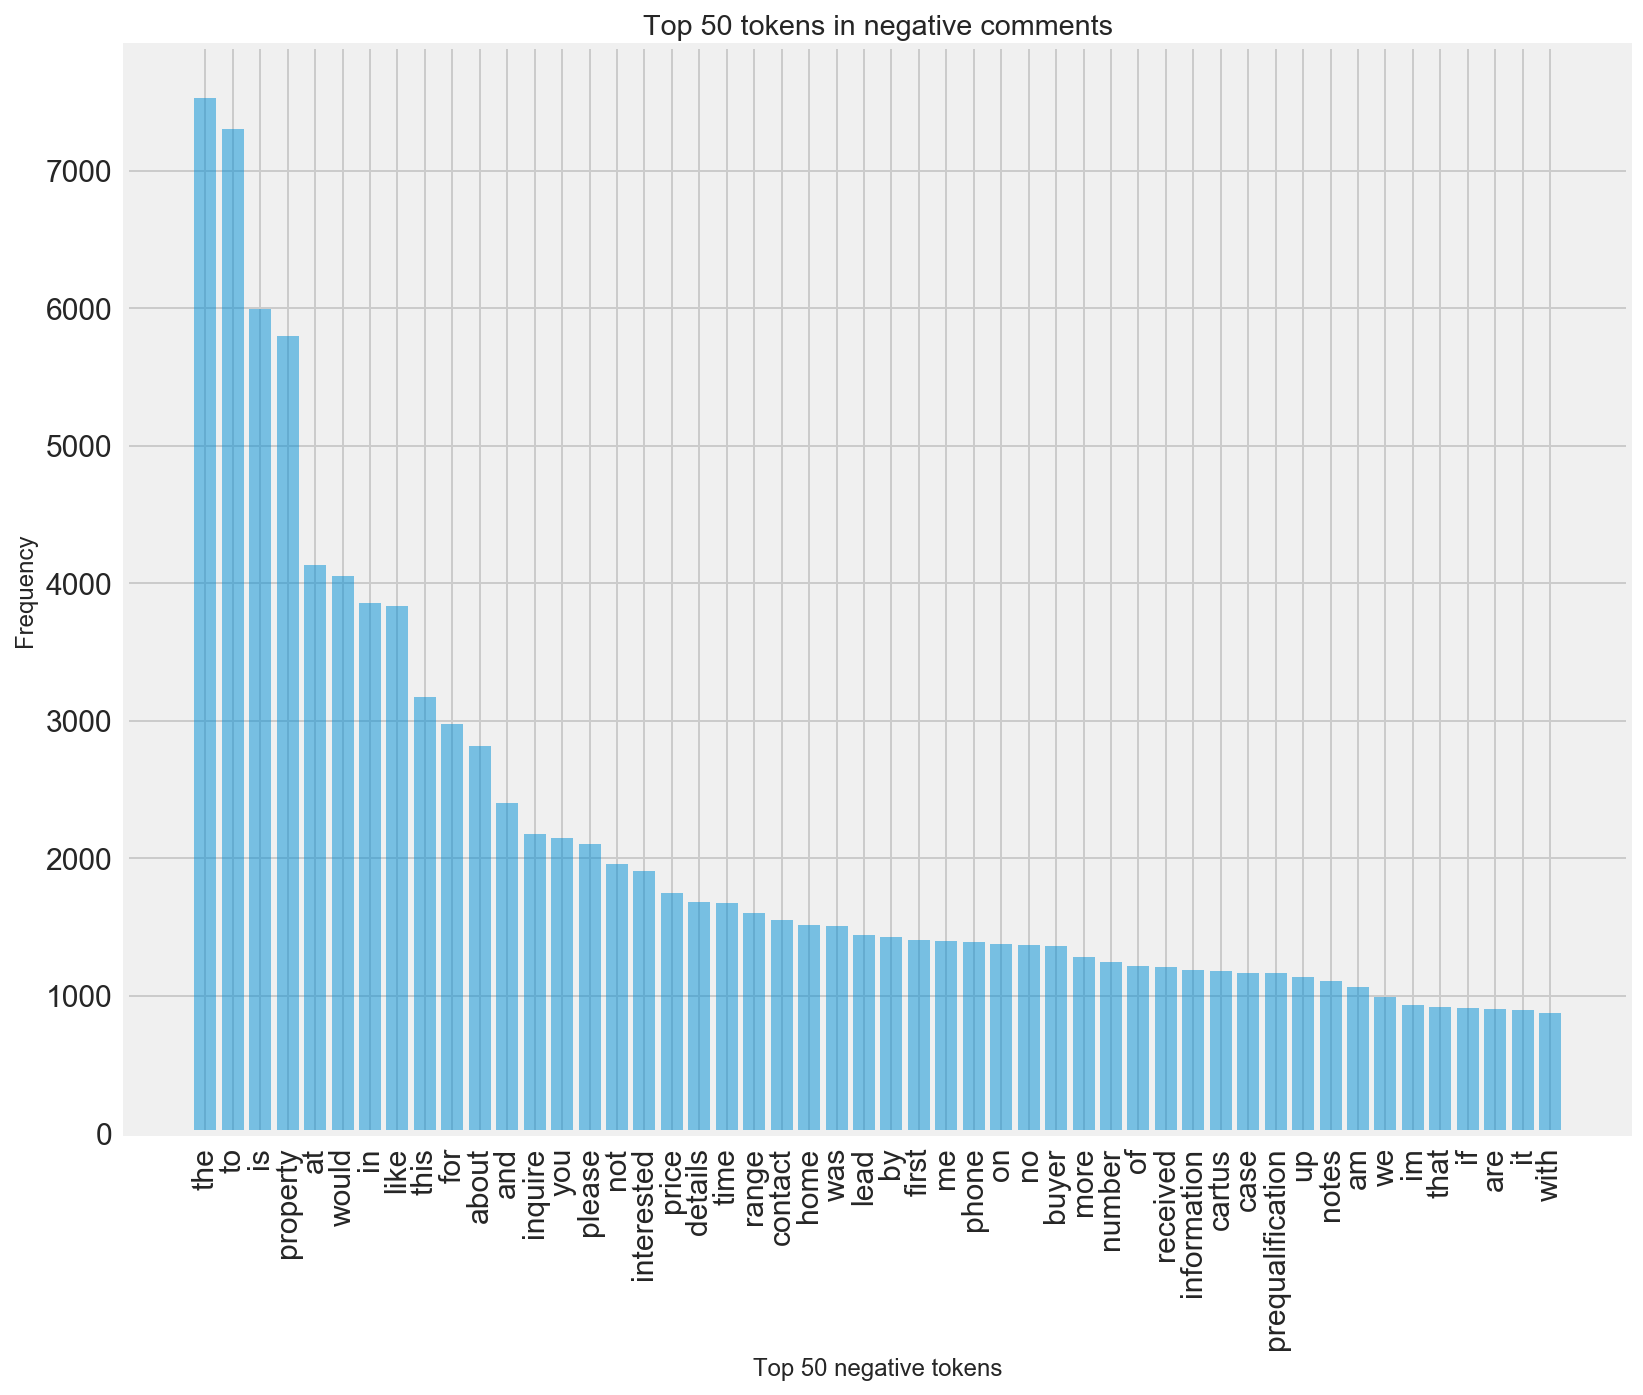

In [111]:
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df.sort_values(by='neg', ascending=False)['neg'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df.sort_values(by='neg', ascending=False)['neg'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 negative tokens')
plt.title('Top 50 tokens in negative comments')

Text(0.5,1,'Top 50 tokens in positive comments')

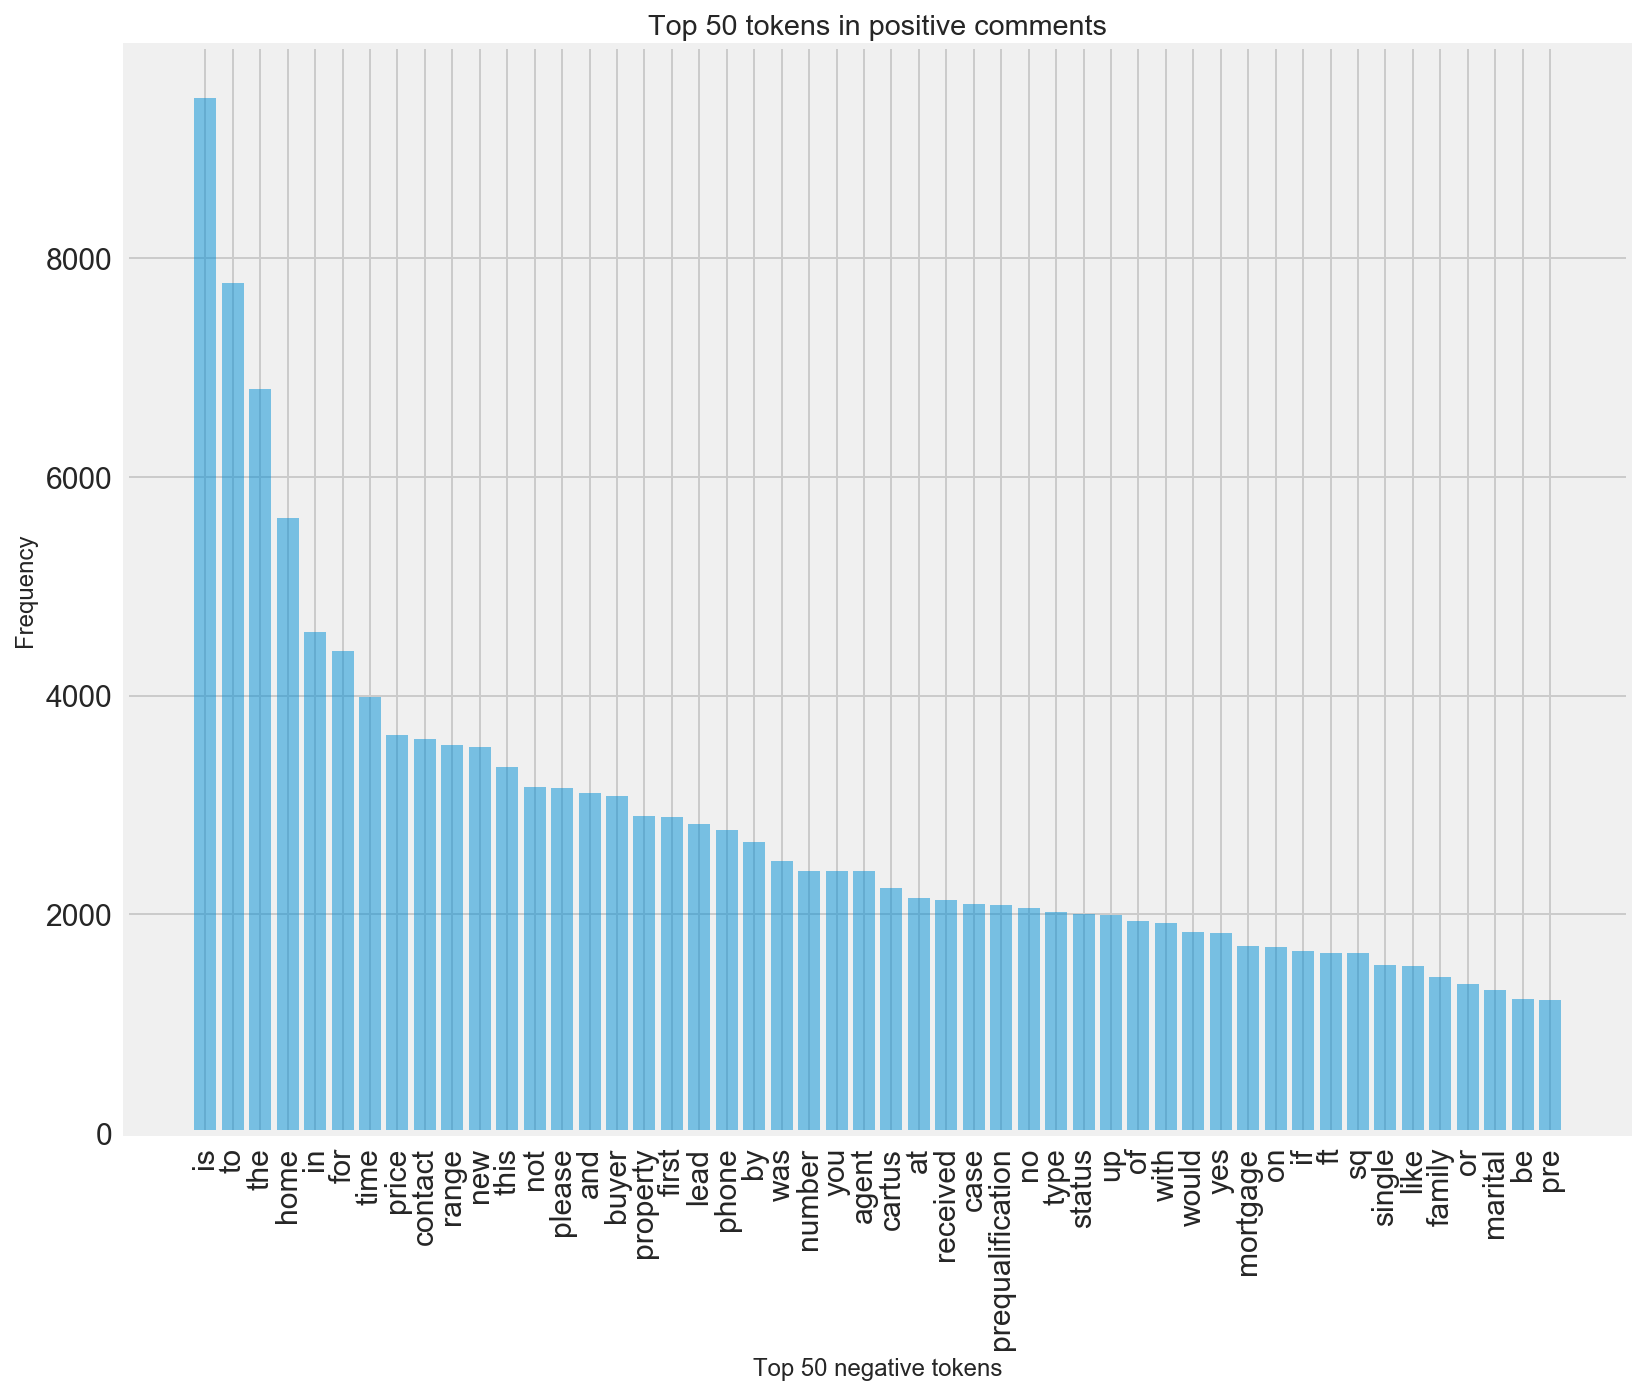

In [112]:
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df.sort_values(by='pos', ascending=False)['pos'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df.sort_values(by='pos', ascending=False)['pos'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 negative tokens')
plt.title('Top 50 tokens in positive comments')

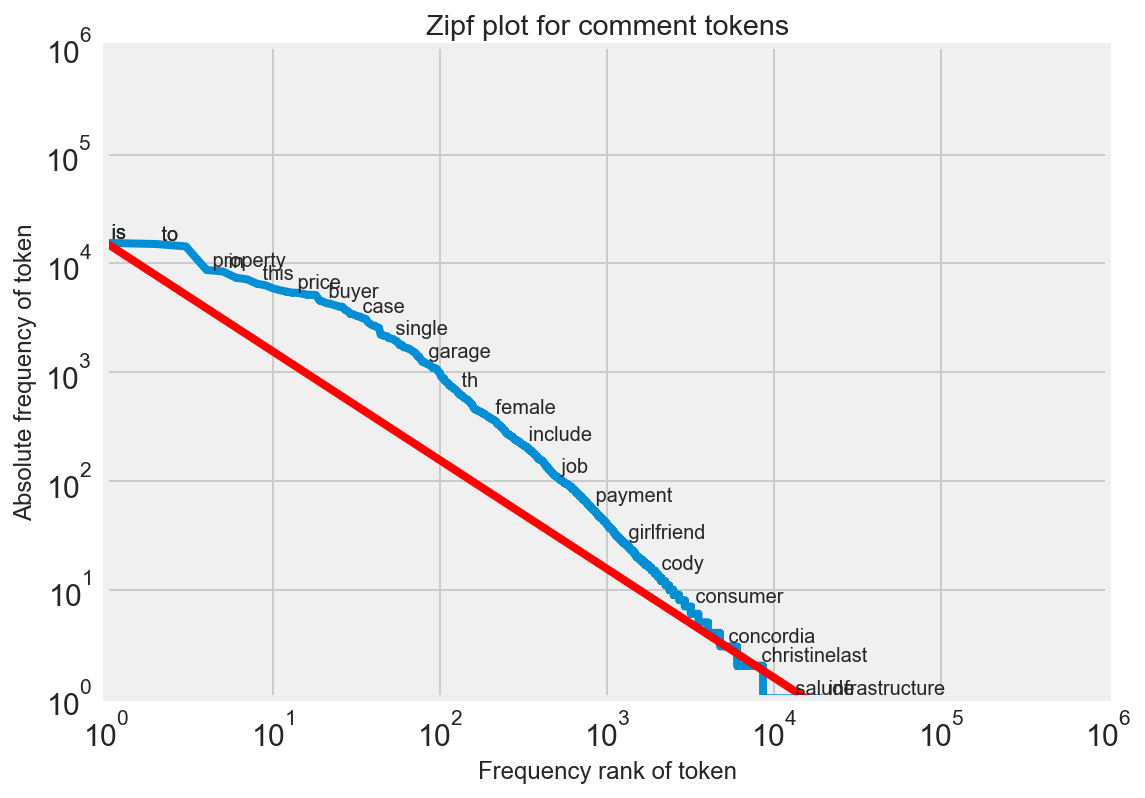

In [108]:
from pylab import *
counts = term_freq_df.total
tokens = term_freq_df.index
ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]
plt.figure(figsize=(8,6))
plt.ylim(1,10**6)
plt.xlim(1,10**6)
loglog(ranks, frequencies, marker=".")
plt.plot([1,frequencies[0]],[frequencies[0],1],color='r')
title("Zipf plot for comment tokens")
xlabel("Frequency rank of token")
ylabel("Absolute frequency of token")
grid(True)
for n in list(logspace(-0.5, log10(len(counts)-2), 25).astype(int)):
    dummy = text(ranks[n], frequencies[n], " " + tokens[indices[n]], 
                 verticalalignment="bottom",
                 horizontalalignment="left")

Text(0.5,1,'Negative Frequency vs Positive Frequency')

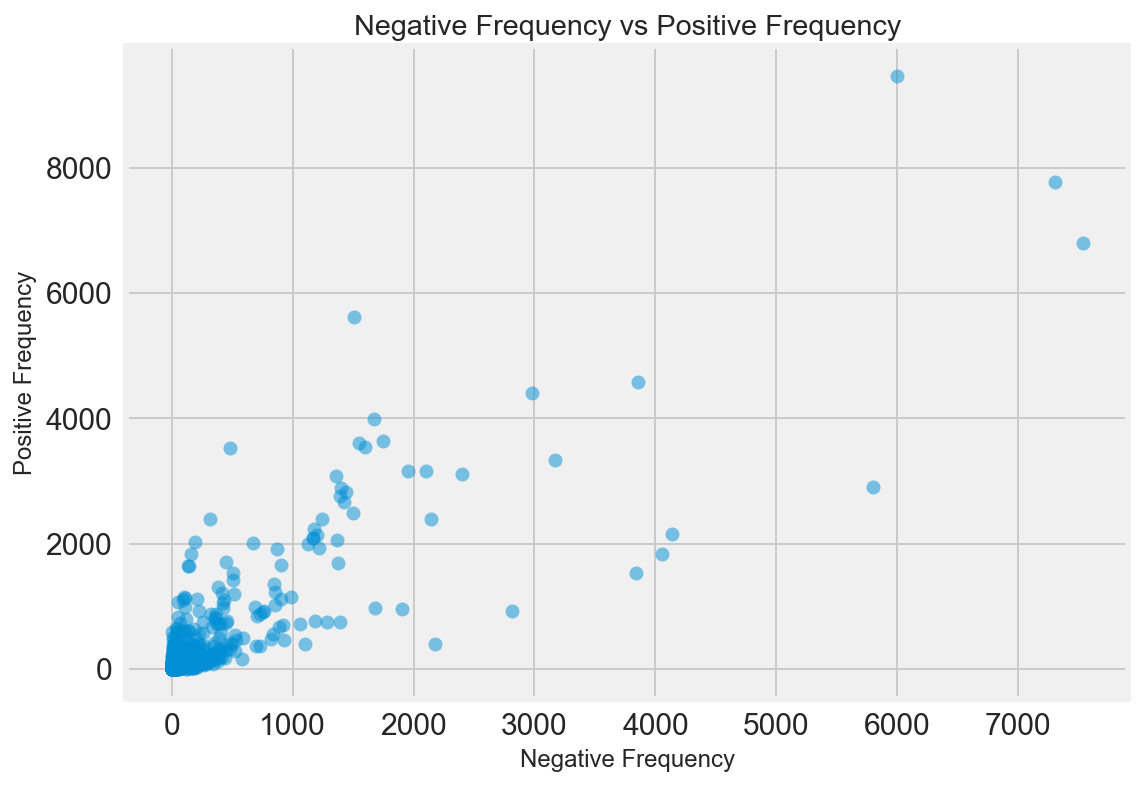

In [115]:
import seaborn as sns
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg", y="pos",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df)
plt.ylabel('Positive Frequency')
plt.xlabel('Negative Frequency')
plt.title('Negative Frequency vs Positive Frequency')

# Split data

In [121]:
x = dd.customer_comment
y = dd["lr_lead_status_name"].apply(lambda x: 0 if x == "Cold" else 1)
from sklearn.cross_validation import train_test_split
SEED = 2000
x_train, x_validation, y_train, y_validation = train_test_split(x, y, test_size=.02, random_state=SEED)

In [122]:
from textblob import TextBlob
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

tbresult = [TextBlob(i).sentiment.polarity for i in x_validation]
tbpred = [0 if n < 0 else 1 for n in tbresult]
conmat = np.array(confusion_matrix(y_validation, tbpred, labels=[1,0]))
confusion = pd.DataFrame(conmat, index=['positive', 'negative'],
                         columns=['predicted_positive','predicted_negative'])
print ("Accuracy Score: {0:.2f}%".format(accuracy_score(y_validation, tbpred)*100))
print ("-"*80)
print ("Confusion Matrix\n")
#print confusion
#print "-"*80
#print "Classification Report\n"
#print classification_report(y_validation, tbpred)

Accuracy Score: 44.94%
--------------------------------------------------------------------------------


# Count Vectorizer

In [123]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from time import time

In [132]:
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print ("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print ("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print ("model has the same accuracy with the null accuracy")
    else:
        print ("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print ("train and test time: {0:.2f}s".format(train_test_time))
    print ("-"*80)
    return accuracy, train_test_time
cvec = CountVectorizer()
lr = LogisticRegression()
n_features = np.arange(10000,100001,10000)
def nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr):
    result = []
    print (classifier)
    print ("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print ("Validation result for {} features".format(n))
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,nfeature_accuracy,tt_time))
    return result

In [133]:
print("RESULT FOR UNIGRAM WITHOUT STOP WORDS\n")
feature_result_wosw = nfeature_accuracy_checker(stop_words='english')
print("RESULT FOR UNIGRAM WITH STOP WORDS\n")
feature_result_ug = nfeature_accuracy_checker()
#print "RESULT FOR UNIGRAM WITHOUT CUSTOM STOP WORDS (Top 10 frequent words)\n"
#feature_result_wocsw = nfeature_accuracy_checker(stop_words=my_stop_words)

RESULT FOR UNIGRAM WITHOUT STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 10000 features
null accuracy: 51.05%
accuracy score: 75.11%
model is 24.05% more accurate than null accuracy
train and test time: 0.87s
--------------------------------------------------------------------------------
Validation result for 20000 features
null accuracy: 51.05%
accuracy score: 75.32%
model is 24.26% more accurate than null accuracy
train and test time: 1.05s
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 51.05%
accuracy score: 75.32%
model is 24.26% more accurate than null accuracy
train and test time: 1.02s
----------------------------------------------------------

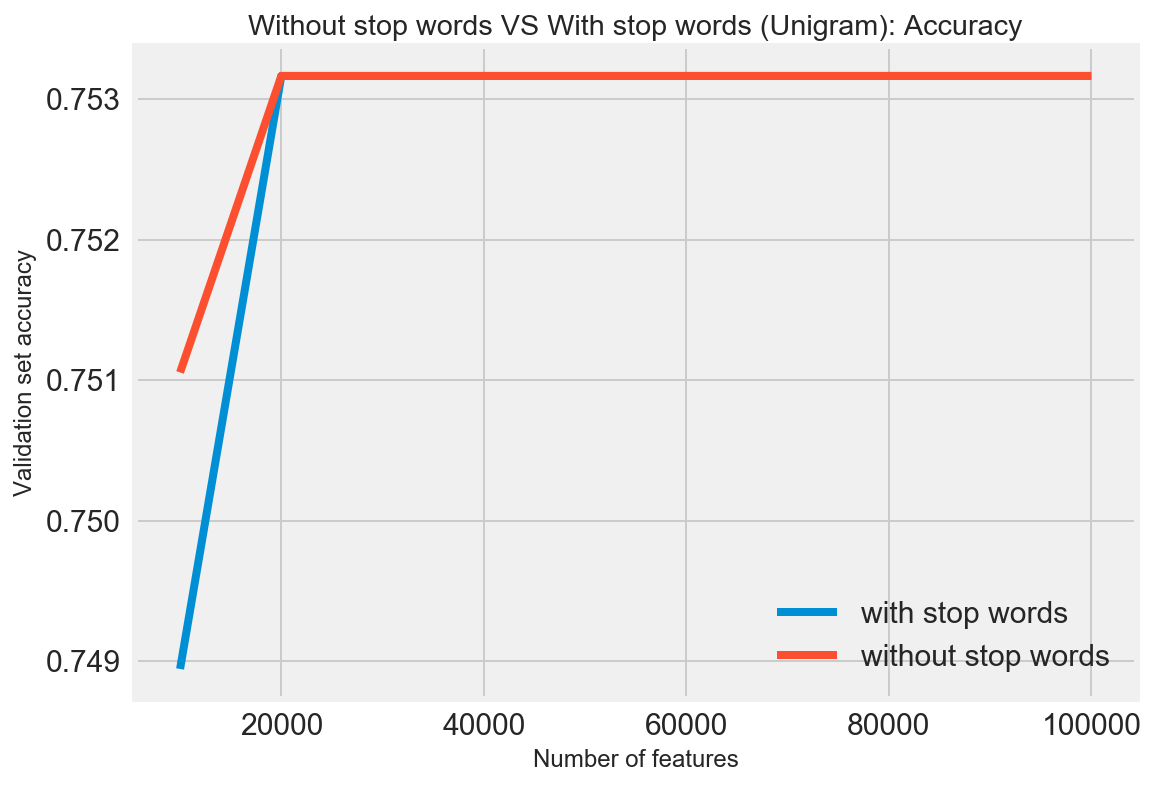

In [134]:
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy','train_test_time'])
#nfeatures_plot_ug_wocsw = pd.DataFrame(feature_result_wocsw,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug_wosw = pd.DataFrame(feature_result_wosw,columns=['nfeatures','validation_accuracy','train_test_time'])
plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='with stop words')
#plt.plot(nfeatures_plot_ug_wocsw.nfeatures, nfeatures_plot_ug_wocsw.validation_accuracy,label='without custom stop words')
plt.plot(nfeatures_plot_ug_wosw.nfeatures, nfeatures_plot_ug_wosw.validation_accuracy,label='without stop words')
plt.title("Without stop words VS With stop words (Unigram): Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

In [135]:
feature_result_bg = nfeature_accuracy_checker(ngram_range=(1, 2))
feature_result_tg = nfeature_accuracy_checker(ngram_range=(1, 3))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 10000 features
null accuracy: 51.05%
accuracy score: 75.32%
model is 24.26% more accurate than null accuracy
train and test time: 2.50s
--------------------------------------------------------------------------------
Validation result for 20000 features
null accuracy: 51.05%
accuracy score: 75.74%
model is 24.68% more accurate than null accuracy
train and test time: 2.52s
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 51.05%
accuracy score: 75.53%
model is 24.47% more accurate than null accuracy
train and test time: 3.27s
--------------------------------------------------------------------------------
Validation resul

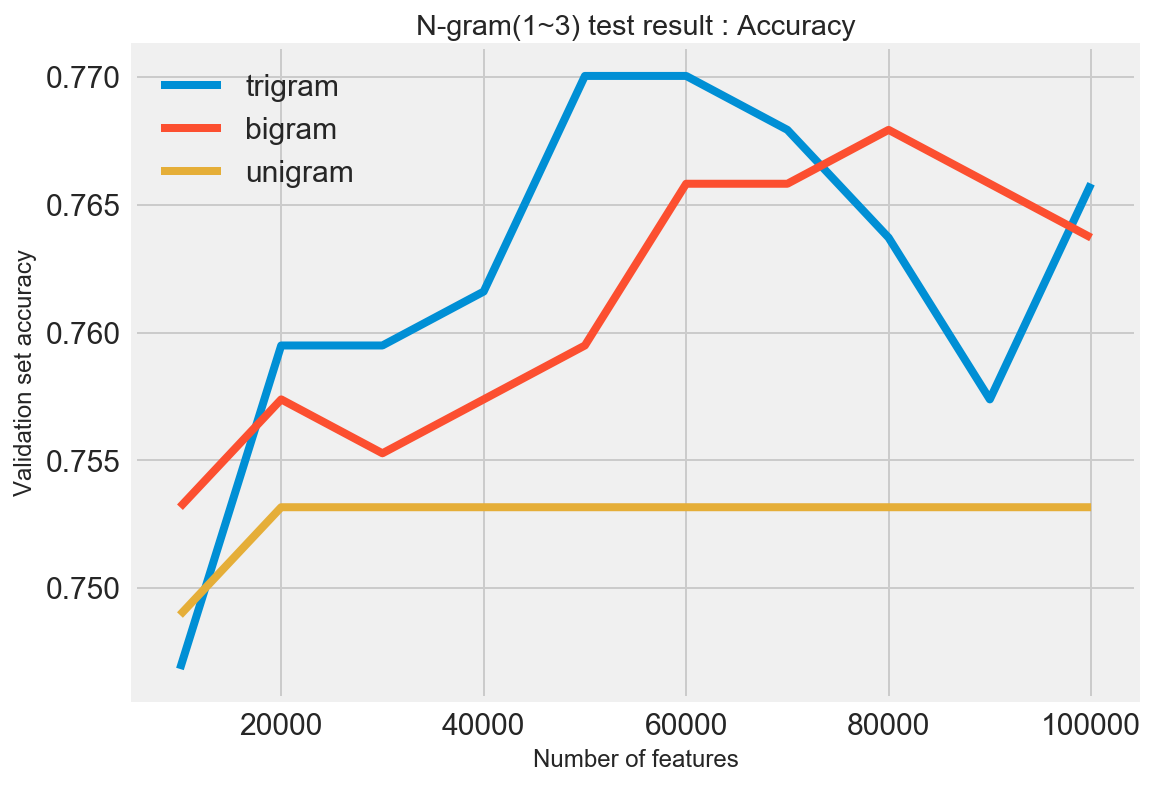

In [136]:
nfeatures_plot_tg = pd.DataFrame(feature_result_tg,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bg = pd.DataFrame(feature_result_bg,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy','train_test_time'])
plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tg.nfeatures, nfeatures_plot_tg.validation_accuracy,label='trigram')
plt.plot(nfeatures_plot_bg.nfeatures, nfeatures_plot_bg.validation_accuracy,label='bigram')
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='unigram')
plt.title("N-gram(1~3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

In [137]:
def train_test_and_evaluate(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    conmat = np.array(confusion_matrix(y_test, y_pred, labels=[0,1]))
    confusion = pd.DataFrame(conmat, index=['negative', 'positive'],
                         columns=['predicted_negative','predicted_positive'])
    print( "null accuracy: {0:.2f}%".format(null_accuracy*100))
    print( "accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print( "model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print( "model has the same accuracy with the null accuracy")
    else:
        print( "model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print( "-"*80)
    print( "Confusion Matrix\n")
    print( confusion)
    print( "-"*80)
    print( "Classification Report\n")
    print( classification_report(y_test, y_pred, target_names=['negative','positive']))

In [138]:
%%time
tg_cvec = CountVectorizer(max_features=80000,ngram_range=(1, 3))
tg_pipeline = Pipeline([
        ('vectorizer', tg_cvec),
        ('classifier', lr)
    ])
train_test_and_evaluate(tg_pipeline, x_train, y_train, x_validation, y_validation)

null accuracy: 51.05%
accuracy score: 76.37%
model is 25.32% more accurate than null accuracy
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_negative  predicted_positive
negative                 182                  60
positive                  52                 180
--------------------------------------------------------------------------------
Classification Report

             precision    recall  f1-score   support

   negative       0.78      0.75      0.76       242
   positive       0.75      0.78      0.76       232

avg / total       0.76      0.76      0.76       474

CPU times: user 7.31 s, sys: 72.6 ms, total: 7.39 s
Wall time: 7.39 s


# Tfidf Vectorizer

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 10000 features
null accuracy: 51.05%
accuracy score: 74.89%
model is 23.84% more accurate than null accuracy
train and test time: 0.71s
--------------------------------------------------------------------------------
Validation result for 20000 features
null accuracy: 51.05%
accuracy score: 74.89%
model is 23.84% more accurate than null accuracy
train and test time: 0.75s
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 51.05%
accuracy score: 74.89%
model is 23.84% more accurate than null accuracy
train and test time: 0.72s
--------------------------------------------------------------------------------
Validation resul

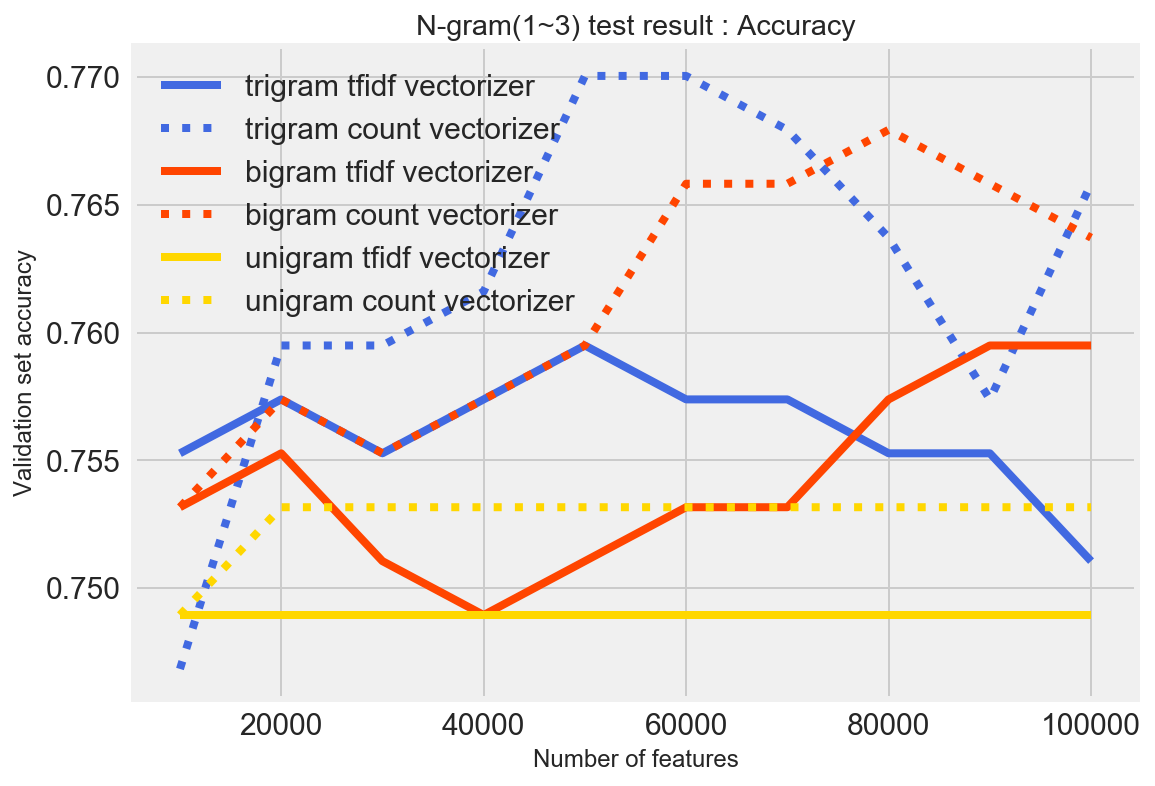

In [139]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from time import time

def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print( "null accuracy: {0:.2f}%".format(null_accuracy*100))
    print( "accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print( "model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print( "model has the same accuracy with the null accuracy")
    else:
        print( "model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print( "train and test time: {0:.2f}s".format(train_test_time))
    print( "-"*80)
    return accuracy, train_test_time

cvec = CountVectorizer()
lr = LogisticRegression()
n_features = np.arange(10000,100001,10000)

def nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr):
    result = []
    print( (classifier))
    print( "\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print( "Validation result for {} features".format(n))
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,nfeature_accuracy,tt_time))
    return result

from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer()

feature_result_ugt = nfeature_accuracy_checker(vectorizer=tvec)
feature_result_bgt = nfeature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 2))
feature_result_tgt = nfeature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 3))


nfeatures_plot_tgt = pd.DataFrame(feature_result_tgt,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bgt = pd.DataFrame(feature_result_bgt,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ugt = pd.DataFrame(feature_result_ugt,columns=['nfeatures','validation_accuracy','train_test_time'])
plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tgt.nfeatures, nfeatures_plot_tgt.validation_accuracy,label='trigram tfidf vectorizer',color='royalblue')
plt.plot(nfeatures_plot_tg.nfeatures, nfeatures_plot_tg.validation_accuracy,label='trigram count vectorizer',linestyle=':', color='royalblue')
plt.plot(nfeatures_plot_bgt.nfeatures, nfeatures_plot_bgt.validation_accuracy,label='bigram tfidf vectorizer',color='orangered')
plt.plot(nfeatures_plot_bg.nfeatures, nfeatures_plot_bg.validation_accuracy,label='bigram count vectorizer',linestyle=':',color='orangered')
plt.plot(nfeatures_plot_ugt.nfeatures, nfeatures_plot_ugt.validation_accuracy, label='unigram tfidf vectorizer',color='gold')
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='unigram count vectorizer',linestyle=':',color='gold')
plt.title("N-gram(1~3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

# Select Features
use SelectPercentile and f_classif to select most important features

In [164]:
from sklearn.feature_selection import SelectPercentile, f_classif

def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print( "null accuracy: {0:.2f}%".format(null_accuracy*100))
    print( "accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print( "model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print( "model has the same accuracy with the null accuracy")
    else:
        print( "model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print( "train and test time: {0:.2f}s".format(train_test_time))
    print( "-"*80)
    return accuracy, train_test_time

cvec = CountVectorizer()
lr = LogisticRegression()
percentile = np.arange(5,40,5)

def nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr):
    result = []
    print( (classifier))
    print( "\n")
    for n in percentile:
        vectorizer.set_params(stop_words=stop_words, ngram_range=ngram_range)
        selector = SelectPercentile(f_classif, percentile=n)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('selector', selector),
            ('classifier', classifier)
        ])
        print( "Validation result for {} features".format(n))
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,nfeature_accuracy,tt_time))
    return result

In [165]:
feature_result = nfeature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 2))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 5 features
null accuracy: 51.05%
accuracy score: 73.42%
model is 22.36% more accurate than null accuracy
train and test time: 1.57s
--------------------------------------------------------------------------------
Validation result for 10 features
null accuracy: 51.05%
accuracy score: 74.05%
model is 23.00% more accurate than null accuracy
train and test time: 1.59s
--------------------------------------------------------------------------------
Validation result for 15 features
null accuracy: 51.05%
accuracy score: 75.53%
model is 24.47% more accurate than null accuracy
train and test time: 1.57s
--------------------------------------------------------------------------------
Validation result for 20 f

# PCA

In [168]:
from sklearn.decomposition import PCA, TruncatedSVD

def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print( "null accuracy: {0:.2f}%".format(null_accuracy*100))
    print( "accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print( "model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print( "model has the same accuracy with the null accuracy")
    else:
        print( "model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print( "train and test time: {0:.2f}s".format(train_test_time))
    print( "-"*80)
    return accuracy, train_test_time

cvec = CountVectorizer()
lr = LogisticRegression()
percentile = np.arange(5,40,5)

def nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr):
    result = []
    print( (classifier))
    print( "\n")
    for n in percentile:
        vectorizer.set_params(stop_words=stop_words, ngram_range=ngram_range)
        pca = TruncatedSVD(n_components=n)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('selector', pca),
            ('classifier', classifier)
        ])
        print( "Validation result for {} features".format(n))
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,nfeature_accuracy,tt_time))
    return result

In [169]:
feature_result = nfeature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 2))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 5 features
null accuracy: 51.05%
accuracy score: 64.98%
model is 13.92% more accurate than null accuracy
train and test time: 1.77s
--------------------------------------------------------------------------------
Validation result for 10 features
null accuracy: 51.05%
accuracy score: 68.57%
model is 17.51% more accurate than null accuracy
train and test time: 1.62s
--------------------------------------------------------------------------------
Validation result for 15 features
null accuracy: 51.05%
accuracy score: 70.25%
model is 19.20% more accurate than null accuracy
train and test time: 1.73s
--------------------------------------------------------------------------------
Validation result for 20 f

# Algorithms Comparison

In [140]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.neighbors import NearestCentroid
from sklearn.feature_selection import SelectFromModel

names = ["Logistic Regression", "Linear SVC", "LinearSVC with L1-based feature selection","Multinomial NB", 
         "Bernoulli NB", "Ridge Classifier", "AdaBoost", "Perceptron","Passive-Aggresive", "Nearest Centroid"]
classifiers = [
    LogisticRegression(),
    LinearSVC(),
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
  ('classification', LinearSVC(penalty="l2"))]),
    MultinomialNB(),
    BernoulliNB(),
    RidgeClassifier(),
    AdaBoostClassifier(),
    Perceptron(),
    PassiveAggressiveClassifier(),
    NearestCentroid()
    ]
zipped_clf = zip(names,classifiers)

tvec = TfidfVectorizer()
def classifier_comparator(vectorizer=tvec, n_features=10000, stop_words=None, ngram_range=(1, 1), classifier=zipped_clf):
    result = []
    vectorizer.set_params(stop_words=stop_words, max_features=n_features, ngram_range=ngram_range)
    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', c)
        ])
        print( "Validation result for {}".format(n))
        print( c)
        clf_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,clf_accuracy,tt_time))
    return result

trigram_result = classifier_comparator(n_features=100000,ngram_range=(1,3))

Validation result for Logistic Regression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
null accuracy: 51.05%
accuracy score: 75.11%
model is 24.05% more accurate than null accuracy
train and test time: 3.11s
--------------------------------------------------------------------------------
Validation result for Linear SVC
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
null accuracy: 51.05%
accuracy score: 76.37%
model is 25.32% more accurate than null accuracy
train and test time: 3.04s
--------------------------------------------------------------------------------
Validation result for LinearSVC with L1-b

/Users/mrahimi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


null accuracy: 51.05%
accuracy score: 70.68%
model is 19.62% more accurate than null accuracy
train and test time: 2.70s
--------------------------------------------------------------------------------
Validation result for Passive-Aggresive
PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
              fit_intercept=True, loss='hinge', max_iter=None, n_iter=None,
              n_jobs=1, random_state=None, shuffle=True, tol=None,
              verbose=0, warm_start=False)


/Users/mrahimi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


null accuracy: 51.05%
accuracy score: 69.83%
model is 18.78% more accurate than null accuracy
train and test time: 2.66s
--------------------------------------------------------------------------------
Validation result for Nearest Centroid
NearestCentroid(metric='euclidean', shrink_threshold=None)
null accuracy: 51.05%
accuracy score: 71.10%
model is 20.04% more accurate than null accuracy
train and test time: 2.84s
--------------------------------------------------------------------------------


In [143]:
from sklearn.ensemble import VotingClassifier

clf1 = LogisticRegression()
clf2 = LinearSVC()
clf3 = MultinomialNB()
clf4 = RidgeClassifier()
clf5 = PassiveAggressiveClassifier()

eclf = VotingClassifier(estimators=[('lr', clf1), ('svc', clf2), ('mnb', clf3), ('rcs', clf4), ('pac', clf5)], voting='hard')

for clf, label in zip([clf1, clf2, clf3, clf4, clf5, eclf], ['Logistic Regression', 'Linear SVC', 'Multinomial NB', 'Ridge Classifier', 'Passive Aggresive Classifier', 'Ensemble']):
    checker_pipeline = Pipeline([
            ('vectorizer', TfidfVectorizer(max_features=100000,ngram_range=(1, 3))),
            ('classifier', clf)
        ])
    print("Validation result for {}".format(label))
    print(clf)
    clf_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)


Validation result for Logistic Regression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
null accuracy: 51.05%
accuracy score: 75.11%
model is 24.05% more accurate than null accuracy
train and test time: 3.18s
--------------------------------------------------------------------------------
Validation result for Linear SVC
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
null accuracy: 51.05%
accuracy score: 76.37%
model is 25.32% more accurate than null accuracy
train and test time: 2.89s
--------------------------------------------------------------------------------
Validation result for Multinomial NB
Mult

/Users/mrahimi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


null accuracy: 51.05%
accuracy score: 75.95%
model is 24.89% more accurate than null accuracy
train and test time: 2.64s
--------------------------------------------------------------------------------
Validation result for Ensemble
VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('svc', Linear...   n_jobs=1, random_state=None, shuffle=True, tol=None,
              verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)
null accuracy: 51.05%
accuracy score: 77.43%
model is 26.37% more accurate than null accuracy
train and test time: 4.17s
--------------------------------------------------------------------------------


/Users/mrahimi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


# Lexical Approach

In [144]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer(max_features=10000)
cvec.fit(x_train)

neg_train = x_train[y_train == 0]
pos_train = x_train[y_train == 1]
neg_doc_matrix = cvec.transform(neg_train)
pos_doc_matrix = cvec.transform(pos_train)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)

from scipy.stats import hmean
from scipy.stats import norm
def normcdf(x):
    return norm.cdf(x, x.mean(), x.std())

neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df2 = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()
term_freq_df2.columns = ['negative', 'positive']
term_freq_df2['total'] = term_freq_df2['negative'] + term_freq_df2['positive']
term_freq_df2['pos_rate'] = term_freq_df2['positive'] * 1./term_freq_df2['total']
term_freq_df2['pos_freq_pct'] = term_freq_df2['positive'] * 1./term_freq_df2['positive'].sum()
term_freq_df2['pos_rate_normcdf'] = normcdf(term_freq_df2['pos_rate'])
term_freq_df2['pos_freq_pct_normcdf'] = normcdf(term_freq_df2['pos_freq_pct'])
term_freq_df2['pos_normcdf_hmean'] = hmean([term_freq_df2['pos_rate_normcdf'], term_freq_df2['pos_freq_pct_normcdf']])
term_freq_df2.sort_values(by='pos_normcdf_hmean', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct,pos_rate_normcdf,pos_freq_pct_normcdf,pos_normcdf_hmean
closed,3,572,575,0.994783,0.001934,0.900788,0.989199,0.942926
prequalified,53,1051,1104,0.951993,0.003554,0.878174,0.999992,0.935132
nfcu,12,506,518,0.976834,0.001711,0.891707,0.978192,0.932949
member,37,647,684,0.945906,0.002188,0.874684,0.995538,0.931206
usaa,52,808,860,0.939535,0.002732,0.870956,0.999511,0.930816
option,46,633,679,0.932253,0.002140,0.866603,0.994700,0.926244
special,89,1091,1180,0.924576,0.003689,0.861906,0.999997,0.925830
ft,132,1617,1749,0.924528,0.005468,0.861876,1.000000,0.925815
sq,133,1612,1745,0.923782,0.005451,0.861413,1.000000,0.925548
prior,29,521,550,0.947273,0.001762,0.875473,0.981296,0.925369


In [146]:
pos_hmean = term_freq_df2.pos_normcdf_hmean

y_val_predicted_proba = []
for t in x_validation:
    hmean_scores = [pos_hmean[w] for w in t.split() if w in pos_hmean.index]
    if len(hmean_scores) > 0:
        prob_score = np.mean(hmean_scores)
    else:
        prob_score = np.random.random()
    y_val_predicted_proba.append(prob_score)
    
pred = [1 if t > 0.50 else 0 for t in y_val_predicted_proba]

from sklearn.metrics import accuracy_score
accuracy_score(y_validation,pred)

0.64345991561181437

# Doc2Vec

In [147]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence
import multiprocessing
from sklearn import utils

def labelize_tweets_ug(tweets,label):
    result = []
    prefix = label
    for i, t in zip(tweets.index, tweets):
        result.append(LabeledSentence(t.split(), [prefix + '_%s' % i]))
    return result
  
all_x = pd.concat([x_train,x_validation])
all_x_w2v = labelize_tweets_ug(all_x, 'all')

/Users/mrahimi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  if sys.path[0] == '':


In [148]:
from sklearn.linear_model import LogisticRegression

cores = multiprocessing.cpu_count()
model_ug_dbow = Doc2Vec(dm=0, size=100, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_dbow.build_vocab([x for x in tqdm(all_x_w2v)])

for epoch in range(30):
    model_ug_dbow.train(utils.shuffle([x for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_dbow.alpha -= 0.002
    model_ug_dbow.min_alpha = model_ug_dbow.alpha
    
def get_vectors(model, corpus, size):
    vecs = np.zeros((len(corpus), size))
    n = 0
    for i in corpus.index:
        prefix = 'all_' + str(i)
        vecs[n] = model.docvecs[prefix]
        n += 1
    return vecs
  
train_vecs_dbow = get_vectors(model_ug_dbow, x_train, 100)
validation_vecs_dbow = get_vectors(model_ug_dbow, x_validation, 100)

clf = LogisticRegression()
clf.fit(train_vecs_dbow, y_train)
clf.score(validation_vecs_dbow, y_validation)

/Users/mrahimi/anaconda3/lib/python3.6/site-packages/gensim/models/doc2vec.py:366: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 23680/23680 [00:00<00:00, 2799355.09it/s]


0.689873417721519

In [149]:
cores = multiprocessing.cpu_count()
model_ug_dmc = Doc2Vec(dm=1, dm_concat=1, size=100, window=2, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_dmc.build_vocab([x for x in tqdm(all_x_w2v)])

for epoch in range(30):
    model_ug_dmc.train(utils.shuffle([x for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_dmc.alpha -= 0.002
    model_ug_dmc.min_alpha = model_ug_dmc.alpha
   
train_vecs_dmc = get_vectors(model_ug_dmc, x_train, 100)
validation_vecs_dmc = get_vectors(model_ug_dmc, x_validation, 100)

clf = LogisticRegression()
clf.fit(train_vecs_dmc, y_train)
clf.score(validation_vecs_dmc, y_validation)

/Users/mrahimi/anaconda3/lib/python3.6/site-packages/gensim/models/doc2vec.py:366: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 23680/23680 [00:00<00:00, 2810683.38it/s]


0.57805907172995785

In [150]:
cores = multiprocessing.cpu_count()
model_ug_dmm = Doc2Vec(dm=1, dm_mean=1, size=100, window=4, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_dmm.build_vocab([x for x in tqdm(all_x_w2v)])

for epoch in range(30):
    model_ug_dmm.train(utils.shuffle([x for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_dmm.alpha -= 0.002
    model_ug_dmm.min_alpha = model_ug_dmm.alpha
    
train_vecs_dmm = get_vectors(model_ug_dmm, x_train, 100)
validation_vecs_dmm = get_vectors(model_ug_dmm, x_validation, 100)

clf = LogisticRegression()
clf.fit(train_vecs_dmm, y_train)
clf.score(validation_vecs_dmm, y_validation)

/Users/mrahimi/anaconda3/lib/python3.6/site-packages/gensim/models/doc2vec.py:366: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 23680/23680 [00:00<00:00, 2652382.60it/s]


0.61603375527426163

In [151]:
def get_concat_vectors(model1,model2, corpus, size):
    vecs = np.zeros((len(corpus), size))
    n = 0
    for i in corpus.index:
        prefix = 'all_' + str(i)
        vecs[n] = np.append(model1.docvecs[prefix],model2.docvecs[prefix])
        n += 1
    return vecs

train_vecs_dbow_dmc = get_concat_vectors(model_ug_dbow,model_ug_dmc, x_train, 200)
validation_vecs_dbow_dmc = get_concat_vectors(model_ug_dbow,model_ug_dmc, x_validation, 200)

clf = LogisticRegression()
clf.fit(train_vecs_dbow_dmc, y_train)
clf.score(validation_vecs_dbow_dmc, y_validation)

0.69409282700421937

In [155]:
model_ug_dbow.similar_by_word("good")

/Users/mrahimi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('pack', 0.3495246171951294),
 ('cathedral', 0.3373924195766449),
 ('sterling', 0.3345503807067871),
 ('southington', 0.3213658928871155),
 ('aarons', 0.3196079134941101),
 ('duran', 0.3102021813392639),
 ('primarily', 0.30287596583366394),
 ('homepath', 0.29752108454704285),
 ('burlington', 0.2923700213432312),
 ('certain', 0.29202860593795776)]

In [156]:
model_ug_dmc.similar_by_word("good")

/Users/mrahimi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('wonderful', 0.5523840188980103),
 ('terrible', 0.5404798984527588),
 ('great', 0.524941086769104),
 ('responsiveness', 0.45335403084754944),
 ('garner', 0.43521007895469666),
 ('suitable', 0.4328100383281708),
 ('nice', 0.42824888229370117),
 ('flight', 0.4259353280067444),
 ('wyndham', 0.41780707240104675),
 ('engaging', 0.415477991104126)]